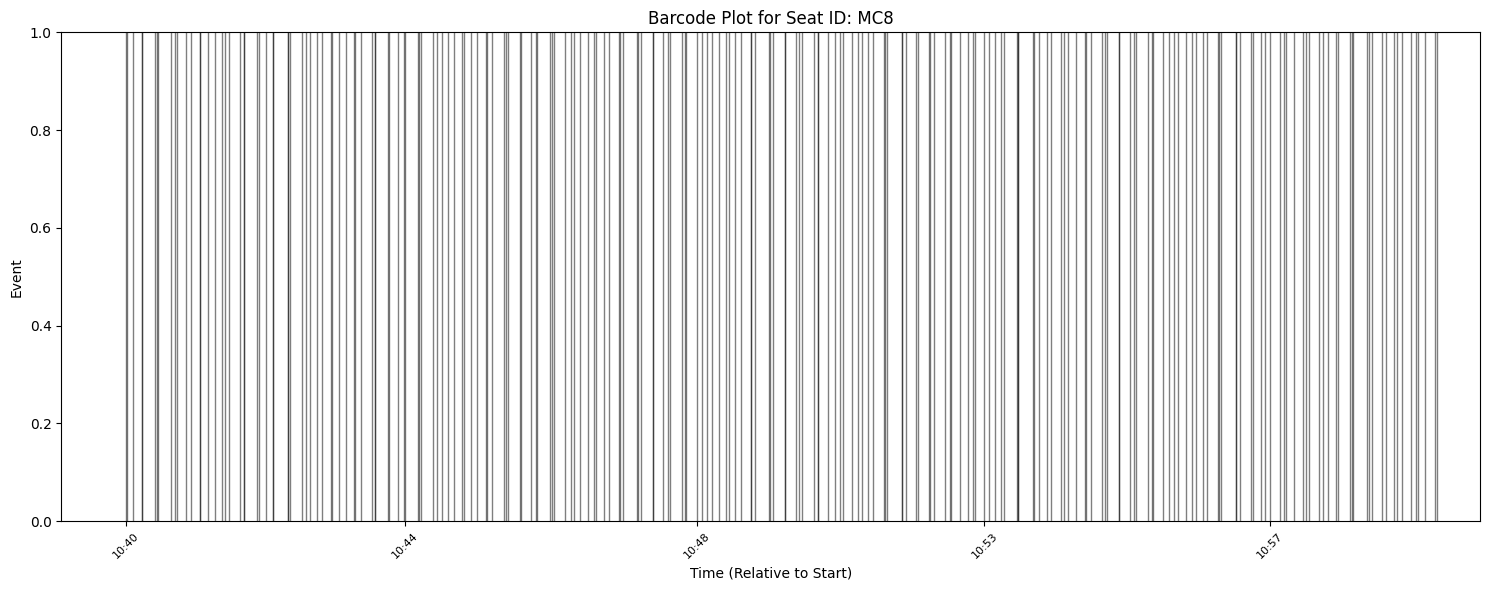

In [1]:
import matplotlib.pyplot as plt
import json
from datetime import datetime

def load_timestamps_from_file(file_path, seat_id, day, start_time=None, end_time=None):
    """
    Load the text file, parse it for a given seat ID, and extract timestamps where the seat ID appeared.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.

    Returns:
        list: A list of timestamps (acp_ts) where the seat ID was detected within the timeframe.
    """
    timestamps = []

    # Convert start and end times to UNIX timestamps
    start_timestamp = (
        datetime.strptime(f"{day} {start_time}", "%Y-%m-%d %H:%M").timestamp() if start_time else None
    )
    end_timestamp = (
        datetime.strptime(f"{day} {end_time}", "%Y-%m-%d %H:%M").timestamp() if end_time else None
    )

    # Load and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
                ts = float(data['acp_ts'])
                if seat_id in data.get('seats_occupied', []) and (
                    start_timestamp is None or ts >= start_timestamp
                ) and (end_timestamp is None or ts <= end_timestamp):
                    timestamps.append(ts)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}\nError: {e}")
    
    return timestamps

def plot_seat_barcode(file_path, seat_id, day, bar_width=1, xtick_interval=10, start_time=None, end_time=None):
    """
    Load timestamps for a given seat ID and plot them as a barcode, optionally filtering by a timeframe.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        bar_width (float): Width of the vertical bars.
        xtick_interval (int): Interval for x-ticks to avoid overcrowding.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.
    """
    timestamps = load_timestamps_from_file(file_path, seat_id, day, start_time, end_time)

    if not timestamps:
        print(f"No data found for seat ID: {seat_id} in the specified timeframe.")
        return

    # Normalise timestamps to start from 0
    min_timestamp = min(timestamps)
    normalised_timestamps = [ts - min_timestamp for ts in timestamps]

    # Plot the timestamps as barcodes
    plt.figure(figsize=(15, 6))
    for ts in normalised_timestamps:
        plt.axvline(x=ts, color='black', linestyle='-', alpha=0.5, linewidth=bar_width)

    # Set x-ticks at regular intervals
    xtick_positions = normalised_timestamps[::xtick_interval] if xtick_interval > 0 else normalised_timestamps
    xtick_labels = [datetime.fromtimestamp(ts + min_timestamp).strftime('%H:%M') for ts in xtick_positions]
    plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45, fontsize=8)

    # Adding labels and grid for clarity
    plt.title(f"Barcode Plot for Seat ID: {seat_id}")
    plt.xlabel('Time (Relative to Start)')
    plt.ylabel('Event')
    plt.tight_layout()
    plt.show()

# Example usage:
day = '2024-01-24'
file_path = './node_22-28Jan/cerberus-node-lt1_'+day+'.txt'
seat_id = 'MC8'
start_time = '10:40'
end_time = '11:00'
plot_seat_barcode(file_path, seat_id, day, bar_width=1, xtick_interval=50, start_time=start_time, end_time=end_time)


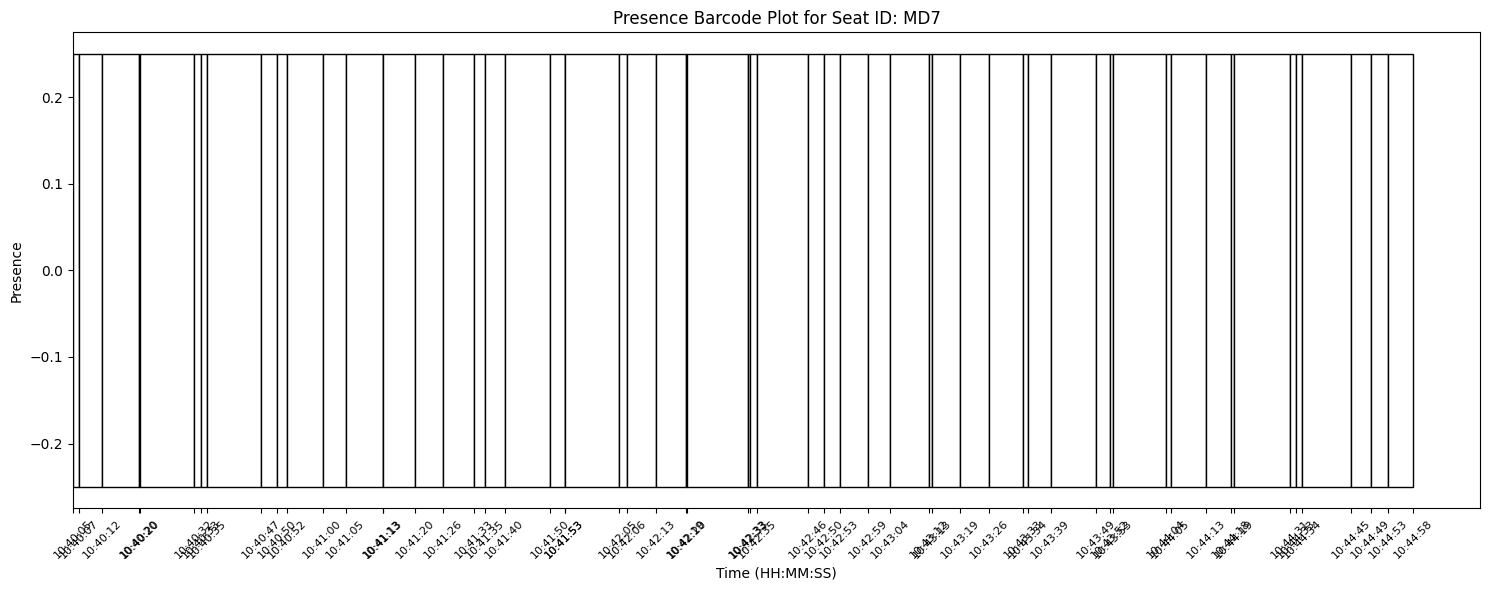

In [7]:
import matplotlib.pyplot as plt
import json
from datetime import datetime

def load_timestamps_with_presence(file_path, seat_id, day, start_time=None, end_time=None):
    """
    Load the text file, parse it for a given seat ID, and extract timestamps along with presence information.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.

    Returns:
        list: A list of tuples (timestamp, is_present) indicating presence of the seat ID.
    """
    data_points = []

    # Convert start and end times to UNIX timestamps
    start_timestamp = (
        datetime.strptime(f"{day} {start_time}", "%Y-%m-%d %H:%M").timestamp() if start_time else None
    )
    end_timestamp = (
        datetime.strptime(f"{day} {end_time}", "%Y-%m-%d %H:%M").timestamp() if end_time else None
    )

    # Load and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
                ts = float(data['acp_ts'])
                is_present = seat_id in data.get('seats_occupied', [])
                if (start_timestamp is None or ts >= start_timestamp) and (end_timestamp is None or ts <= end_timestamp):
                    data_points.append((ts, is_present))
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}\nError: {e}")

    return data_points
def plot_seat_presence_barcode(file_path, seat_id, day, bar_height=1, start_time=None, end_time=None):
    """
    Plot presence and absence of a given seat ID using rectangles, based on the parsed data.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        bar_height (float): Height of the rectangles.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.
    """
    data_points = load_timestamps_with_presence(file_path, seat_id, day, start_time, end_time)

    if not data_points:
        print(f"No data found for seat ID: {seat_id} in the specified timeframe.")
        return

    # Sort the data points by timestamp
    data_points.sort(key=lambda x: x[0])

    # Extract timestamps and find minimum timestamp for normalisation
    timestamps = [dp[0] for dp in data_points]
    min_timestamp = min(timestamps)
    normalised_data = [(ts - min_timestamp, is_present) for ts, is_present in data_points]

    # Prepare the plot
    plt.figure(figsize=(15, 6))

    for i in range(len(normalised_data) - 1):
        ts_start, is_present = normalised_data[i]
        ts_end, _ = normalised_data[i + 1]
        width = ts_end - ts_start

        # Draw a rectangle for the current time interval
        colour = 'black' if is_present else 'white'
        plt.barh(0, width, left=ts_start, height=bar_height, color=colour, edgecolor='black')

    # Set x-ticks and labels
    xtick_positions = [ts for ts, _ in normalised_data]
    xtick_labels = [datetime.fromtimestamp(ts + min_timestamp).strftime('%H:%M:%S') for ts, _ in normalised_data]

    plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45, fontsize=8)
    plt.title(f"Presence Barcode Plot for Seat ID: {seat_id}")
    plt.xlabel('Time (HH:MM:SS)')
    plt.ylabel('Presence')
    plt.tight_layout()
    plt.show()


# Example usage:
day = '2024-01-24'
file_path = './node_22-28Jan/cerberus-node-lt1_' + day + '.txt'
seat_id = 'MD7'
start_time = '10:40'
end_time = '10:45'
plot_seat_presence_barcode(file_path, seat_id, day, bar_height=0.5, start_time=start_time, end_time=end_time)


In [17]:
def get_seat_presence_data(file_path, seat_id, day, start_time=None, end_time=None):
    """
    Generate a data structure of all timestamps with 0 for absence and 1 for presence of a specific seat ID.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.

    Returns:
        list: A list of dictionaries with timestamps and presence information.
              Example: [{'timestamp': 1706107398.9274578, 'presence': 1}, ...]
    """
    data_points = []

    # Convert start and end times to UNIX timestamps
    start_timestamp = (
        datetime.strptime(f"{day} {start_time}", "%Y-%m-%d %H:%M").timestamp() if start_time else None
    )
    end_timestamp = (
        datetime.strptime(f"{day} {end_time}", "%Y-%m-%d %H:%M").timestamp() if end_time else None
    )

    # Load and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
                ts = float(data['acp_ts'])
                is_present = 1 if seat_id in data.get('seats_occupied', []) else 0
                if (start_timestamp is None or ts >= start_timestamp) and (end_timestamp is None or ts <= end_timestamp):
                    data_points.append({'timestamp': ts, 'presence': is_present})
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}\\nError: {e}")

    return data_points

# Example Usage
day = '2024-01-24'
file_path = './node_22-28Jan/cerberus-node-lt1_' + day + '.txt'
seat_id = 'MF3'
start_time = '10:40'
end_time = '11:00'

presence_data = get_seat_presence_data(file_path, seat_id, day, start_time, end_time)
for entry in presence_data[:5]:  # Display first 5 entries for verification
    print(entry)


{'timestamp': 1706092805.8460944, 'presence': 1}
{'timestamp': 1706092807.177029, 'presence': 1}
{'timestamp': 1706092812.2422984, 'presence': 1}
{'timestamp': 1706092820.3942158, 'presence': 1}
{'timestamp': 1706092820.466753, 'presence': 1}


In [18]:
len(presence_data)

230

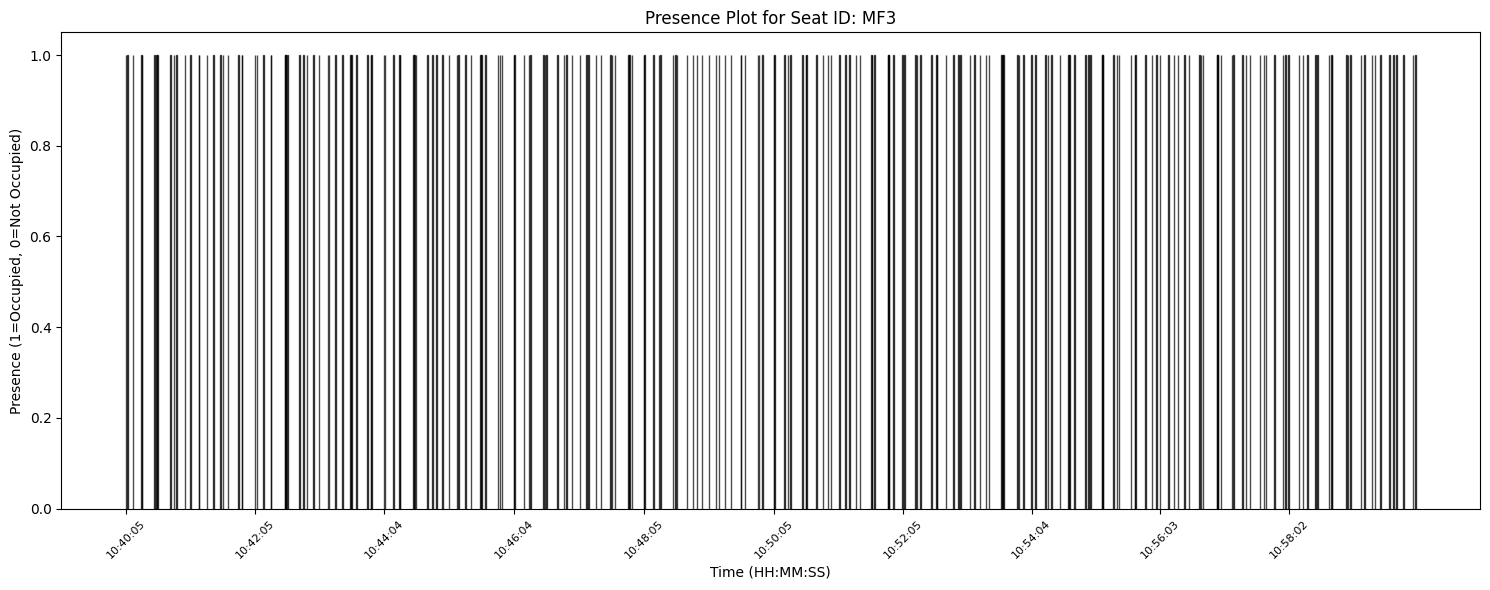

In [25]:
def plot_seat_presence(presence_data, seat_id, bar_height=0.5):
    """
    Plot presence data for a given seat ID as a time series.

    Args:
        presence_data (list): List of dictionaries with 'timestamp' and 'presence' keys.
        seat_id (str): The seat ID being analysed.
        bar_height (float): The thickness of the bars for visual clarity.
    """
    if not presence_data:
        print(f"No presence data available for seat ID: {seat_id}")
        return

    # Extract timestamps and presence values
    timestamps = [entry['timestamp'] for entry in presence_data]
    presence = [entry['presence'] for entry in presence_data]

    # Normalise timestamps to start from 0 for better readability
    min_timestamp = min(timestamps)
    normalised_timestamps = [ts - min_timestamp for ts in timestamps]

    # Plot the presence data
    plt.figure(figsize=(15, 6))
    plt.bar(normalised_timestamps, presence, width=bar_height, color='black', edgecolor='black', alpha=0.7)

    # Format the x-axis to show human-readable time
    xtick_positions = normalised_timestamps[::max(1, len(normalised_timestamps) // 10)]
    xtick_labels = [datetime.fromtimestamp(ts + min_timestamp).strftime('%H:%M:%S') for ts in xtick_positions]
    plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45, fontsize=8)

    # Add labels and title
    plt.title(f"Presence Plot for Seat ID: {seat_id}")
    plt.xlabel('Time (HH:MM:SS)')
    plt.ylabel('Presence (1=Occupied, 0=Not Occupied)')
    plt.tight_layout()
    plt.show()

# Example Usage
plot_seat_presence(presence_data, seat_id='MF3')


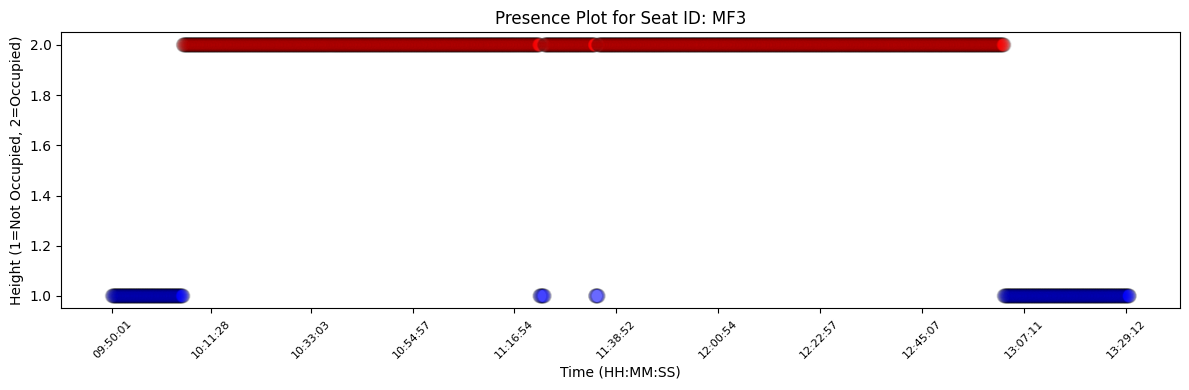

In [39]:
def get_seat_presence_data(file_path, seat_id, day, start_time=None, end_time=None):
    """
    Generate a data structure of all timestamps with 0 for absence and 1 for presence of a specific seat ID.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.

    Returns:
        list: A list of dictionaries with timestamps and presence information.
              Example: [{'timestamp': 1706107398.9274578, 'presence': 1}, ...]
    """
    data_points = []

    # Convert start and end times to UNIX timestamps
    start_timestamp = (
        datetime.strptime(f"{day} {start_time}", "%Y-%m-%d %H:%M").timestamp() if start_time else None
    )
    end_timestamp = (
        datetime.strptime(f"{day} {end_time}", "%Y-%m-%d %H:%M").timestamp() if end_time else None
    )

    # Load and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
                ts = float(data['acp_ts'])
                is_present = 1 if seat_id in data.get('seats_occupied', []) else 0
                if (start_timestamp is None or ts >= start_timestamp) and (end_timestamp is None or ts <= end_timestamp):
                    data_points.append({'timestamp': ts, 'presence': is_present})
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}\nError: {e}")

    return data_points

def plot_seat_presence(presence_data, seat_id):
    """
    Plot presence data for a given seat ID with red and blue circles.

    Args:
        presence_data (list): List of dictionaries with 'timestamp' and 'presence' keys.
        seat_id (str): The seat ID being analysed.
    """
    if not presence_data:
        print(f"No presence data available for seat ID: {seat_id}")
        return

    # Extract timestamps and presence values
    timestamps = [entry['timestamp'] for entry in presence_data]
    presence = [entry['presence'] for entry in presence_data]

    # Normalise timestamps to start from 0 for better readability
    min_timestamp = min(timestamps)
    normalised_timestamps = [ts - min_timestamp for ts in timestamps]

    # Determine heights and colours for circles
    heights = [2 if p == 1 else 1 for p in presence]
    colours = ['red' if p == 1 else 'blue' for p in presence]

    # Plot the presence data as circles
    plt.figure(figsize=(12, 4))
    plt.scatter(normalised_timestamps, heights, c=colours, s=100, edgecolor='black', alpha=0.1)

    # Format the x-axis to show human-readable time
    xtick_positions = normalised_timestamps[::max(1, len(normalised_timestamps) // 10)]
    xtick_labels = [datetime.fromtimestamp(ts + min_timestamp).strftime('%H:%M:%S') for ts in xtick_positions]
    plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45, fontsize=8)

    # Add labels and title
    plt.title(f"Presence Plot for Seat ID: {seat_id}")
    plt.xlabel('Time (HH:MM:SS)')
    plt.ylabel('Height (1=Not Occupied, 2=Occupied)')
    plt.tight_layout()
    plt.show()

# Example Usage
day = '2024-01-24'
file_path = './node_22-28Jan/cerberus-node-lt1_' + day + '.txt'
start_time = '9:50'
end_time = '13:30'

seat_id = 'MF3'
presence_data = get_seat_presence_data(file_path, seat_id, day, start_time, end_time)
plot_seat_presence(presence_data, seat_id)


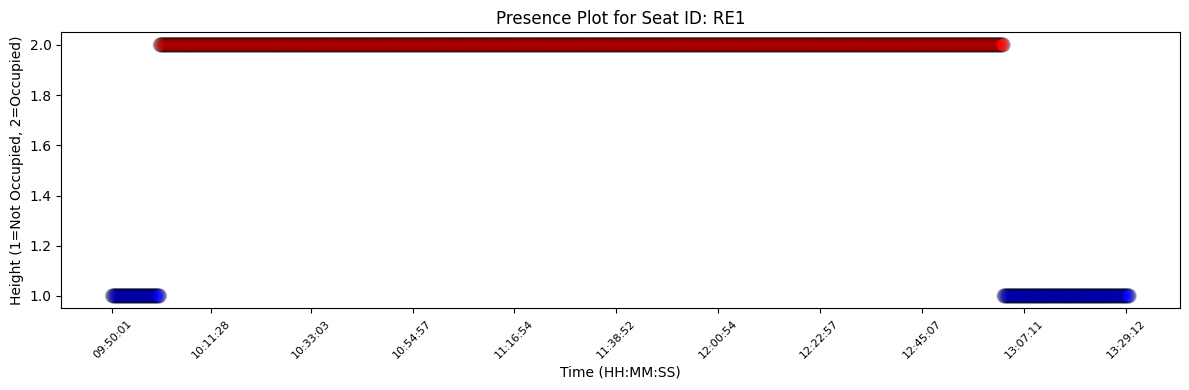

In [40]:
seat_id = 'RE1'
presence_data = get_seat_presence_data(file_path, seat_id, day, start_time, end_time)
plot_seat_presence(presence_data, seat_id)

In [41]:
seat_selection=["LA1", "LF3", "LD3", "LL5", "RE1", "RC1", "RD2", "RC2", "RE3", "RD3", "RI4", "RC4", "RC5", "RI6", "ME2", "MB2", "MG3", "MF3", "MC3", "MA3", "MF4", "MD4", "MC4", "MB4", "ME5", "MD5", "ME6", "MD6", "MB6", "ME7", "MC7", "MB7", "ME8", "MD8", "MC8", "MB8", "MG9", "MF9", "ME9", "MD9", "MC9", "MB9", "MA9", "MF10", "MD10", "MC10", "MG13", "MF13", "MG14"]

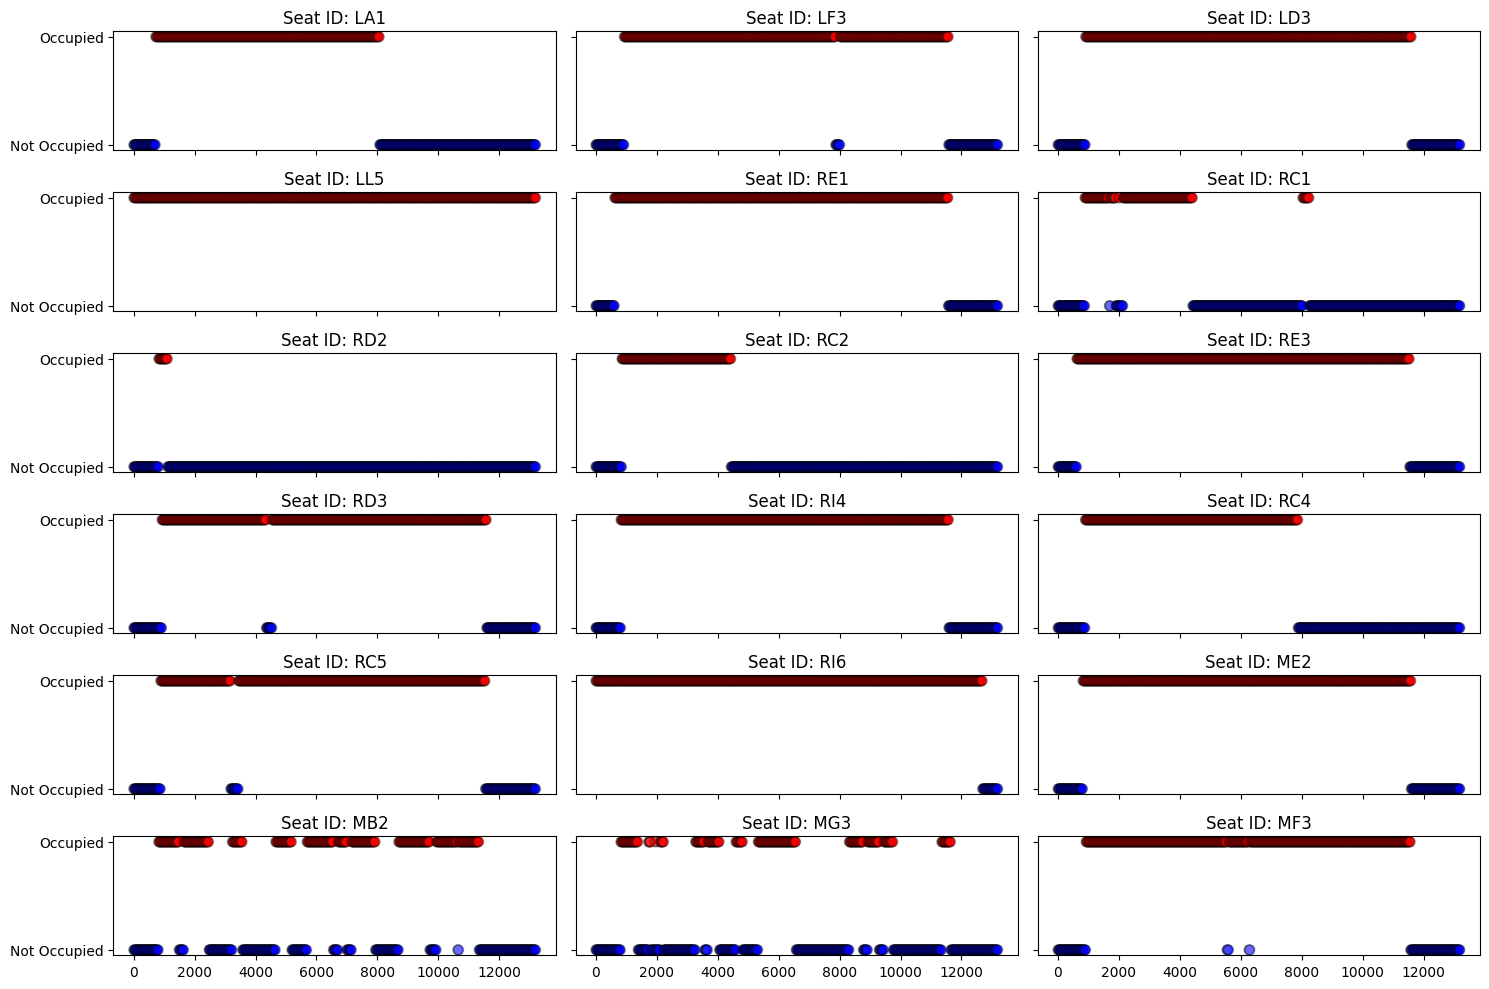

In [45]:

def get_seat_presence_data(file_path, seat_id, day, start_time=None, end_time=None):
    """
    Generate a data structure of all timestamps with 0 for absence and 1 for presence of a specific seat ID.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.

    Returns:
        list: A list of dictionaries with timestamps and presence information.
              Example: [{'timestamp': 1706107398.9274578, 'presence': 1}, ...]
    """
    data_points = []

    # Convert start and end times to UNIX timestamps
    start_timestamp = (
        datetime.strptime(f"{day} {start_time}", "%Y-%m-%d %H:%M").timestamp() if start_time else None
    )
    end_timestamp = (
        datetime.strptime(f"{day} {end_time}", "%Y-%m-%d %H:%M").timestamp() if end_time else None
    )

    # Load and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
                ts = float(data['acp_ts'])
                is_present = 1 if seat_id in data.get('seats_occupied', []) else 0
                if (start_timestamp is None or ts >= start_timestamp) and (end_timestamp is None or ts <= end_timestamp):
                    data_points.append({'timestamp': ts, 'presence': is_present})
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}\nError: {e}")

    return data_points

def plot_multiple_seats_presence(file_path, seat_ids, day, start_time=None, end_time=None, grid_shape=(4, 5)):
    """
    Plot presence data for multiple seat IDs in a single figure with subplots.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_ids (list): List of seat IDs to plot.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.
        grid_shape (tuple): Tuple specifying the grid shape (rows, cols) for subplots.
    """
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, seat_id in enumerate(seat_ids):
        if i >= len(axes):
            break

        presence_data = get_seat_presence_data(file_path, seat_id, day, start_time, end_time)

        if not presence_data:
            axes[i].set_title(f"Seat ID: {seat_id}\nNo Data")
            axes[i].axis('off')
            continue

        # Extract timestamps and presence values
        timestamps = [entry['timestamp'] for entry in presence_data]
        presence = [entry['presence'] for entry in presence_data]

        # Normalise timestamps to start from 0 for better readability
        min_timestamp = min(timestamps)
        normalised_timestamps = [ts - min_timestamp for ts in timestamps]

        # Determine heights and colours for circles
        heights = [2 if p == 1 else 1 for p in presence]
        colours = ['red' if p == 1 else 'blue' for p in presence]

        # Plot the presence data as circles
        axes[i].scatter(normalised_timestamps, heights, c=colours, s=50, edgecolor='black', alpha=0.1)
        axes[i].set_title(f"Seat ID: {seat_id}")
        axes[i].set_yticks([1, 2])
        axes[i].set_yticklabels(['Not Occupied', 'Occupied'])

    # Adjust layout
    for j in range(len(seat_ids), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
day = '2024-01-24'
file_path = './node_22-28Jan/cerberus-node-lt1_' + day + '.txt'
start_time = '9:50'
end_time = '13:30'


seat_ids = seat_selection # ['MD7', 'LL5', 'MF3', 'RK3', 'LL6']  # Add more seat IDs as needed


plot_multiple_seats_presence(file_path, seat_ids, day, start_time, end_time, grid_shape=(6, 3))


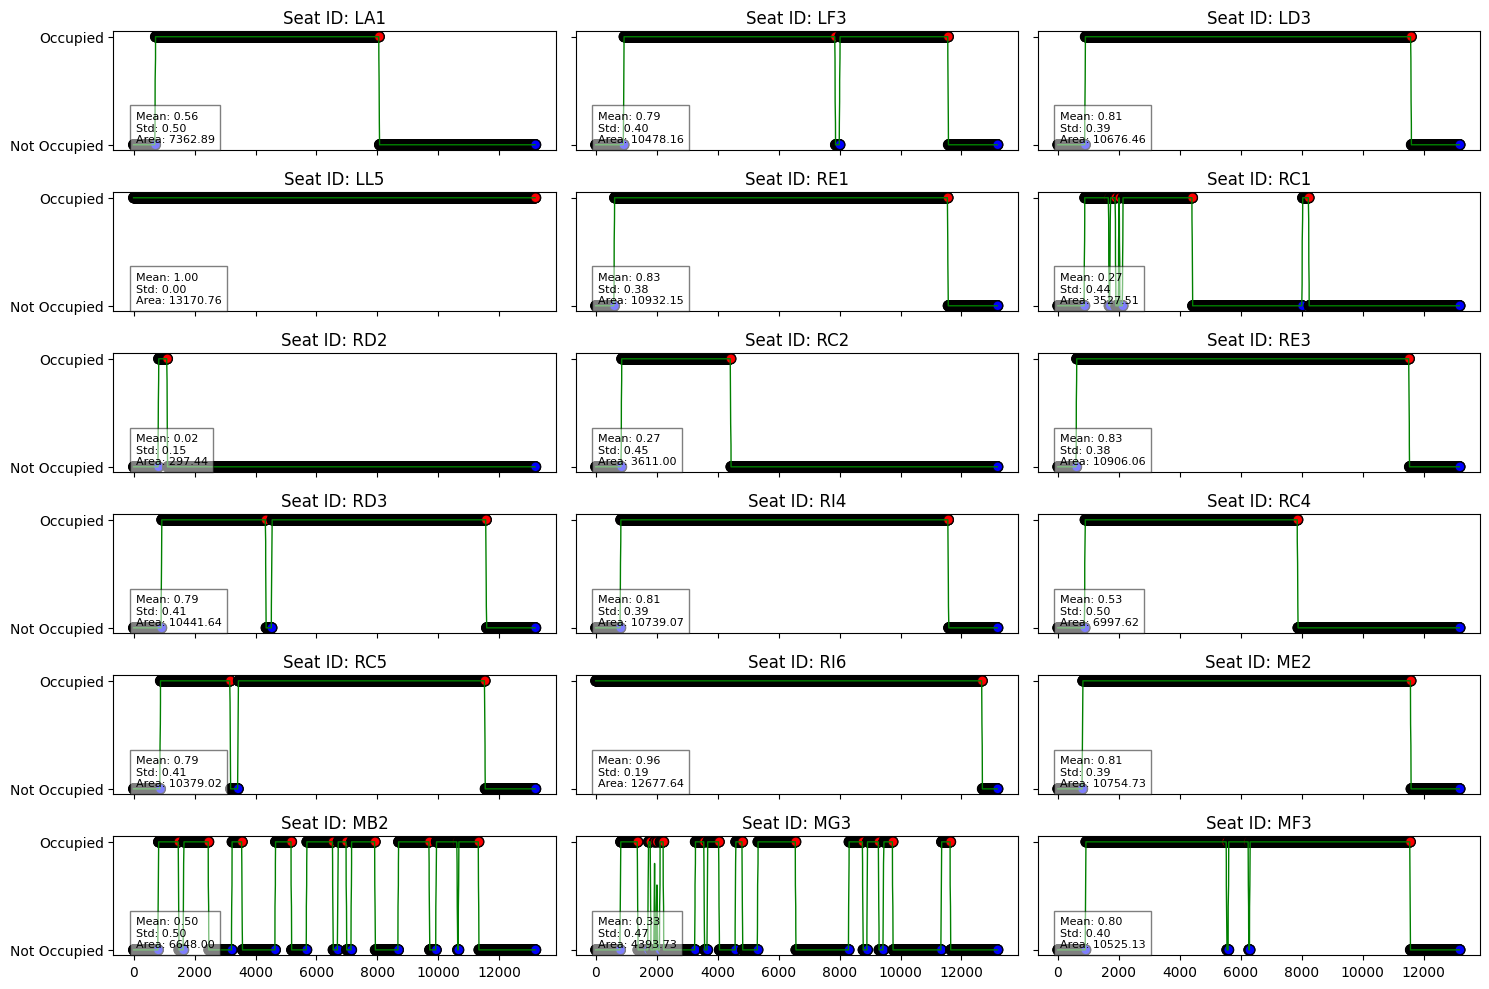

In [52]:

def get_seat_presence_data(file_path, seat_id, day, start_time=None, end_time=None):
    """
    Generate a data structure of all timestamps with 0 for absence and 1 for presence of a specific seat ID.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_id (str): The seat ID to filter by.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.

    Returns:
        list: A list of dictionaries with timestamps and presence information.
              Example: [{'timestamp': 1706107398.9274578, 'presence': 1}, ...]
    """
    data_points = []

    # Convert start and end times to UNIX timestamps
    start_timestamp = (
        datetime.strptime(f"{day} {start_time}", "%Y-%m-%d %H:%M").timestamp() if start_time else None
    )
    end_timestamp = (
        datetime.strptime(f"{day} {end_time}", "%Y-%m-%d %H:%M").timestamp() if end_time else None
    )

    # Load and parse the file
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line)
                ts = float(data['acp_ts'])
                is_present = 1 if seat_id in data.get('seats_occupied', []) else 0
                if (start_timestamp is None or ts >= start_timestamp) and (end_timestamp is None or ts <= end_timestamp):
                    data_points.append({'timestamp': ts, 'presence': is_present})
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {line.strip()}\nError: {e}")

    return data_points

def plot_multiple_seats_presence(file_path, seat_ids, day, start_time=None, end_time=None, grid_shape=(4, 5)):
    """
    Plot presence data for multiple seat IDs in a single figure with subplots.

    Args:
        file_path (str): Path to the JSON line-separated text file.
        seat_ids (list): List of seat IDs to plot.
        day (str): Date of the file in 'YYYY-MM-DD' format.
        start_time (str): Start time in 'HH:MM:SS' format.
        end_time (str): End time in 'HH:MM:SS' format.
        grid_shape (tuple): Tuple specifying the grid shape (rows, cols) for subplots.
    """
    rows, cols = grid_shape
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, seat_id in enumerate(seat_ids):
        if i >= len(axes):
            break

        presence_data = get_seat_presence_data(file_path, seat_id, day, start_time, end_time)

        if not presence_data:
            axes[i].set_title(f"Seat ID: {seat_id}\nNo Data")
            axes[i].axis('off')
            continue

        # Extract timestamps and presence values
        timestamps = [entry['timestamp'] for entry in presence_data]
        presence = [entry['presence'] for entry in presence_data]

        # Normalise timestamps to start from 0 for better readability
        min_timestamp = min(timestamps)
        normalised_timestamps = [ts - min_timestamp for ts in timestamps]

        # Determine heights and colours for circles
        heights = [2 if p == 1 else 1 for p in presence]
        colours = ['red' if p == 1 else 'blue' for p in presence]

        # Plot the presence data as circles
        axes[i].scatter(normalised_timestamps, heights, c=colours, s=50, edgecolor='black', alpha=0.8)

        # Calculate and plot the running average
        running_avg = np.convolve(presence, np.ones(5)/5, mode='valid')
        avg_x = normalised_timestamps[:len(running_avg)]
        axes[i].plot(avg_x, running_avg * (2 - 1) + 1, c='green', label='Running Avg', linewidth=1)

        # Calculate area under the running average
        area_under_curve = np.trapz(running_avg, dx=np.mean(np.diff(avg_x)))

        # Calculate mean and std
        mean_presence = np.mean(presence)
        std_presence = np.std(presence)
        axes[i].text(0.05, 0.05, f"Mean: {mean_presence:.2f}\nStd: {std_presence:.2f}\nArea: {area_under_curve:.2f}",
                     transform=axes[i].transAxes, fontsize=8, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

        # Titles and labels
        axes[i].set_title(f"Seat ID: {seat_id}")
        axes[i].set_yticks([1, 2])
        axes[i].set_yticklabels(['Not Occupied', 'Occupied'])

    # Adjust layout
    for j in range(len(seat_ids), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_multiple_seats_presence(file_path, seat_ids, day, start_time, end_time, grid_shape=(6, 3))
